# **Final Project: Taks 2 - Classification**

## Implementing and evaluating Machine Learning models to predict which subreddit a post came from given its semantic representation. 

### Universidad Carlos III de Madrid - Machine Learning Applications

---

**Authors:**
- Enrique Botía Barberá 
- David Méndez Encinas 
- Andrés Ruiz Calvo 
- Simón E. Sánchez Viloria

## Library imports and downloads

In [1]:
# Common imports 

import numpy as np
import pandas as pd
import zipfile as zp
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored
import time
from mpl_toolkits import mplot3d
import seaborn as sns
import warnings
import pickle


#Gensim imports

!pip install --upgrade gensim==3.8.3
import gensim
from gensim.models import TfidfModel

#Sklearn imports

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

#Pytorch imports

import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

#For fancy table Display
%load_ext google.colab.data_table

#plotting mutiple subplots
!pip install git+git://github.com/simonsanvil/subplotted.git

     |████████████████████████████████| 24.2MB 8.4MB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
  Cloning git://github.com/simonsanvil/subplotted.git to /tmp/pip-req-build-0k27hxwt
  Running command git clone -q git://github.com/simonsanvil/subplotted.git /tmp/pip-req-build-0k27hxwt
  Created wheel for subplotted: filename=subplotted-0.1.0-cp37-none-any.whl size=2619 sha256=9a7472416286c74b1ce86152f7ea4ed585f4c470552769dd36c9c7b687395484
  Stored in directory: /tmp/pip-ephem-wheel-cache-_l0dmas4/wheels/92/9c/47/8b33b2b9966e9d98e298f88695373aaec5a7afb2359bd532f0
Successfully built subplotted


In [2]:
import os       #import os to set environment variable
def install_java():
    !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
    os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
    !java -version       #check java version
install_java()

!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

os.environ['MALLET_HOME'] = 'mallet-2.0.8'
mallet_path = 'mallet-2.0.8/bin/mallet' # you should NOT need to change this

#Gensim imports
from gensim.models.wrappers import LdaMallet
from gensim.models.wrappers.ldamallet import malletmodel2ldamodel
from subplotted import subplotted

openjdk version "11.0.11" 2021-04-20
OpenJDK Runtime Environment (build 11.0.11+9-Ubuntu-0ubuntu2.18.04)
OpenJDK 64-Bit Server VM (build 11.0.11+9-Ubuntu-0ubuntu2.18.04, mixed mode, sharing)
--2021-05-16 16:51:26--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  11.1MB/s    in 1.4s    

2021-05-16 16:51:27 (11.1 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.0.8/bin/csv2vectors  
  inflating: mallet-2.0.8/bin/mallet  
  inflating: mallet-2.0.8/bin/malle

In [3]:
from google.colab import drive
#drive.mount('/content/drive')

## Load the data

Here we load the data that will be used for the analysis and define some functions that will be used to handle it in a convenient way. 

In [4]:
from ast import literal_eval
reddit_df = pd.read_excel('https://storage.googleapis.com/enver-bucket/data/REDDIT_df_topics.xlsx') #Get the reddit_df of the other notebook to get the LDA representation vector
reddit_df['LDA_10'] = reddit_df['LDA_10'].apply(literal_eval)

In [5]:
def list2dict(list): #Transforms the list of sparse vectors into a dictionary to have an easier way to make the new classification df
  dictio_list = []
  for i in range(0,len(list)):
    itemDict = {item[0]: item[1] for item in list[i]}
    dictio_list.append(itemDict)
  return dictio_list

In [6]:
def labelizer(df): #Transforms the subreddit strings into an integer encoding and returns a dictionary to get the strings from the new ID's
  counter = 0
  subreddit2label = {}
  for i in df.subreddit.unique():
    subreddit2label.update({counter:i})
    df.loc[df.subreddit == i,["labels"]] = int(counter)
    counter += 1
  return subreddit2label

## 1. LDA representation

For this part of the classification we are going to use the LDA vector representations that we have obtained on Task 1 of this project.

In [7]:
dictio_list_LDA = list2dict(reddit_df['LDA_10'])
LDA_df = pd.DataFrame(dictio_list_LDA)
LDA_df = LDA_df[[0,1,2,3,4,5,6,7,8,9]]
LDA_df.fillna(0,inplace=True) #As the initial vector came in an sparse form, we need to fill the nans with zeroes
LDA_df["subreddit"] = reddit_df['subreddit']
LDA_df["labels"] = int(0)

subreddit2label = labelizer(LDA_df)

LDA_df.drop("subreddit",inplace=True,axis=1)

In [8]:
LDA_df.head(10) #We can visualize the new df that we are going to use in the classification task

,0,1,2,3,4,5,6,7,8,9,labels
0,0.000000,0.000000,0.000000,0.014954,0.000000,0.027115,0.024621,0.012041,0.787168,0.121295,0
1,0.117327,0.000000,0.026719,0.023802,0.000000,0.000000,0.318747,0.143201,0.244034,0.108522,0
2,0.010001,0.000000,0.000000,0.048910,0.000000,0.046662,0.000000,0.010414,0.753288,0.099259,0
3,0.044844,0.029205,0.035965,0.044906,0.140578,0.041595,0.000000,0.045261,0.554687,0.060660,0
4,0.000000,0.000000,0.020730,0.402794,0.000000,0.033692,0.083191,0.000000,0.124055,0.312967,0
5,0.062661,0.000000,0.000000,0.142168,0.000000,0.000000,0.073860,0.142317,0.341190,0.211341,0
6,0.000000,0.000000,0.000000,0.074065,0.041904,0.011961,0.000000,0.000000,0.646340,0.211662,0
7,0.000000,0.016325,0.000000,0.096744,0.013993,0.050391,0.049842,0.000000,0.678765,0.080011,0
8,0.023112,0.010258,0.000000,0.094141,0.046939,0.000000,0.016597,0.016298,0.613727,0.170115,0
9,0.000000,0.035395,0.000000,0.149184,0.058931,0.000000,0.000000,0.010415,0.544534,0.189273,0


In [9]:
#We create two df one with the vectors and one with the labels
X = LDA_df.drop("labels",axis=1)
y = LDA_df["labels"]

In [10]:
#We make a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 1.1 Data Visualization using Dimensionality Reduction Techniques

Now that we have the LDA vector in a dataframe form, we can apply some reduction techniques to project the data into 2 dimension in order to see the distribution of the data

{0: 'medicine', 1: 'books', 2: 'datascience', 3: 'truegaming', 4: 'PoliticalDiscussion', 5: 'DebateReligion', 6: 'investing', 7: 'relationships', 8: 'CasualConversation', 9: 'legaladvice'}


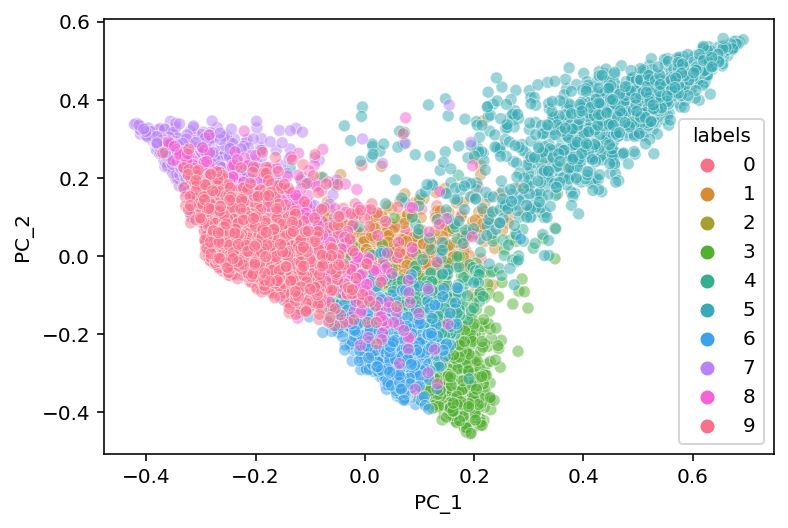

In [11]:
my_pca = PCA(n_components=2).fit(X)
P_data = my_pca.transform(X)
PCA_df = pd.DataFrame(P_data)
dictio = {0: 'PC_1',1: 'PC_2'}
PCA_df.rename(columns=dictio,inplace=True)

sns.scatterplot(x=PCA_df["PC_1"],y=PCA_df["PC_2"],hue=y,palette="husl",legend="full",alpha=0.5,)
print(subreddit2label)

First we can see the PCA projection with 2 components 

{0: 'medicine', 1: 'books', 2: 'datascience', 3: 'truegaming', 4: 'PoliticalDiscussion', 5: 'DebateReligion', 6: 'investing', 7: 'relationships', 8: 'CasualConversation', 9: 'legaladvice'}


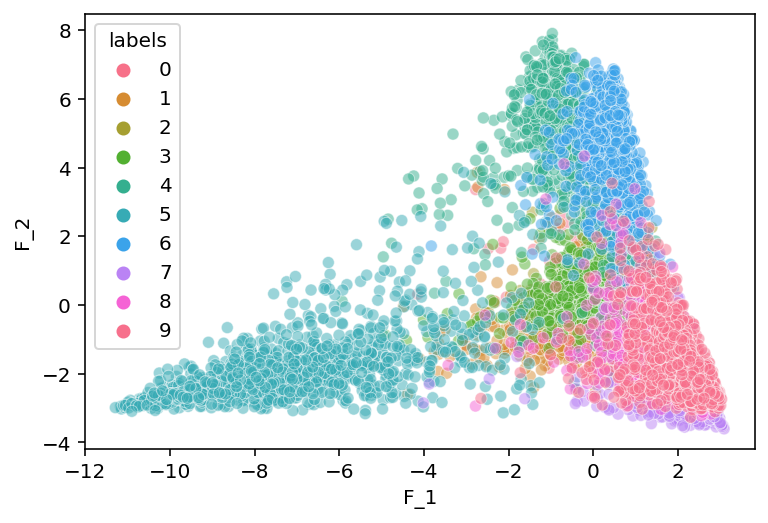

In [12]:
my_fisher = LinearDiscriminantAnalysis(n_components=2).fit(X,y)
F_data = my_fisher.transform(X)
FDA_df = pd.DataFrame(F_data)

dictio = {0: 'F_1',1: 'F_2'}
FDA_df.rename(columns=dictio,inplace=True)

sns.scatterplot(x=FDA_df["F_1"],y=FDA_df["F_2"],hue=y,palette="husl",legend="full",alpha=0.5,)
print(subreddit2label)

And now another projection using FDA

### 1.2 Unsupervised Classification based on assigned LDA topics

Since reddit forums (subreddits) are oftenly about a certain subject there's a clear relationship between them and traditional topics obtained from doing semantic modeling. For this reason, we've considered a Latent Dirichlet Allocation model with 10 topics to model in the hopes that the topics obtained are related to the subjects of the 10 respective subreddits of the dataset. This could be seen as an Unsupervised approach to solving the classification task as the LDA model only receives as input the bag of words obtained from the text in each post of the dataset.

In Task 1, we've implemented and analyzed an LDA model and validated the number of topics using coherence models. In this approach we'll consider a new LDA model but using only a fixed number of 10 topics, the same number of target labels (subreddits) to classify. 

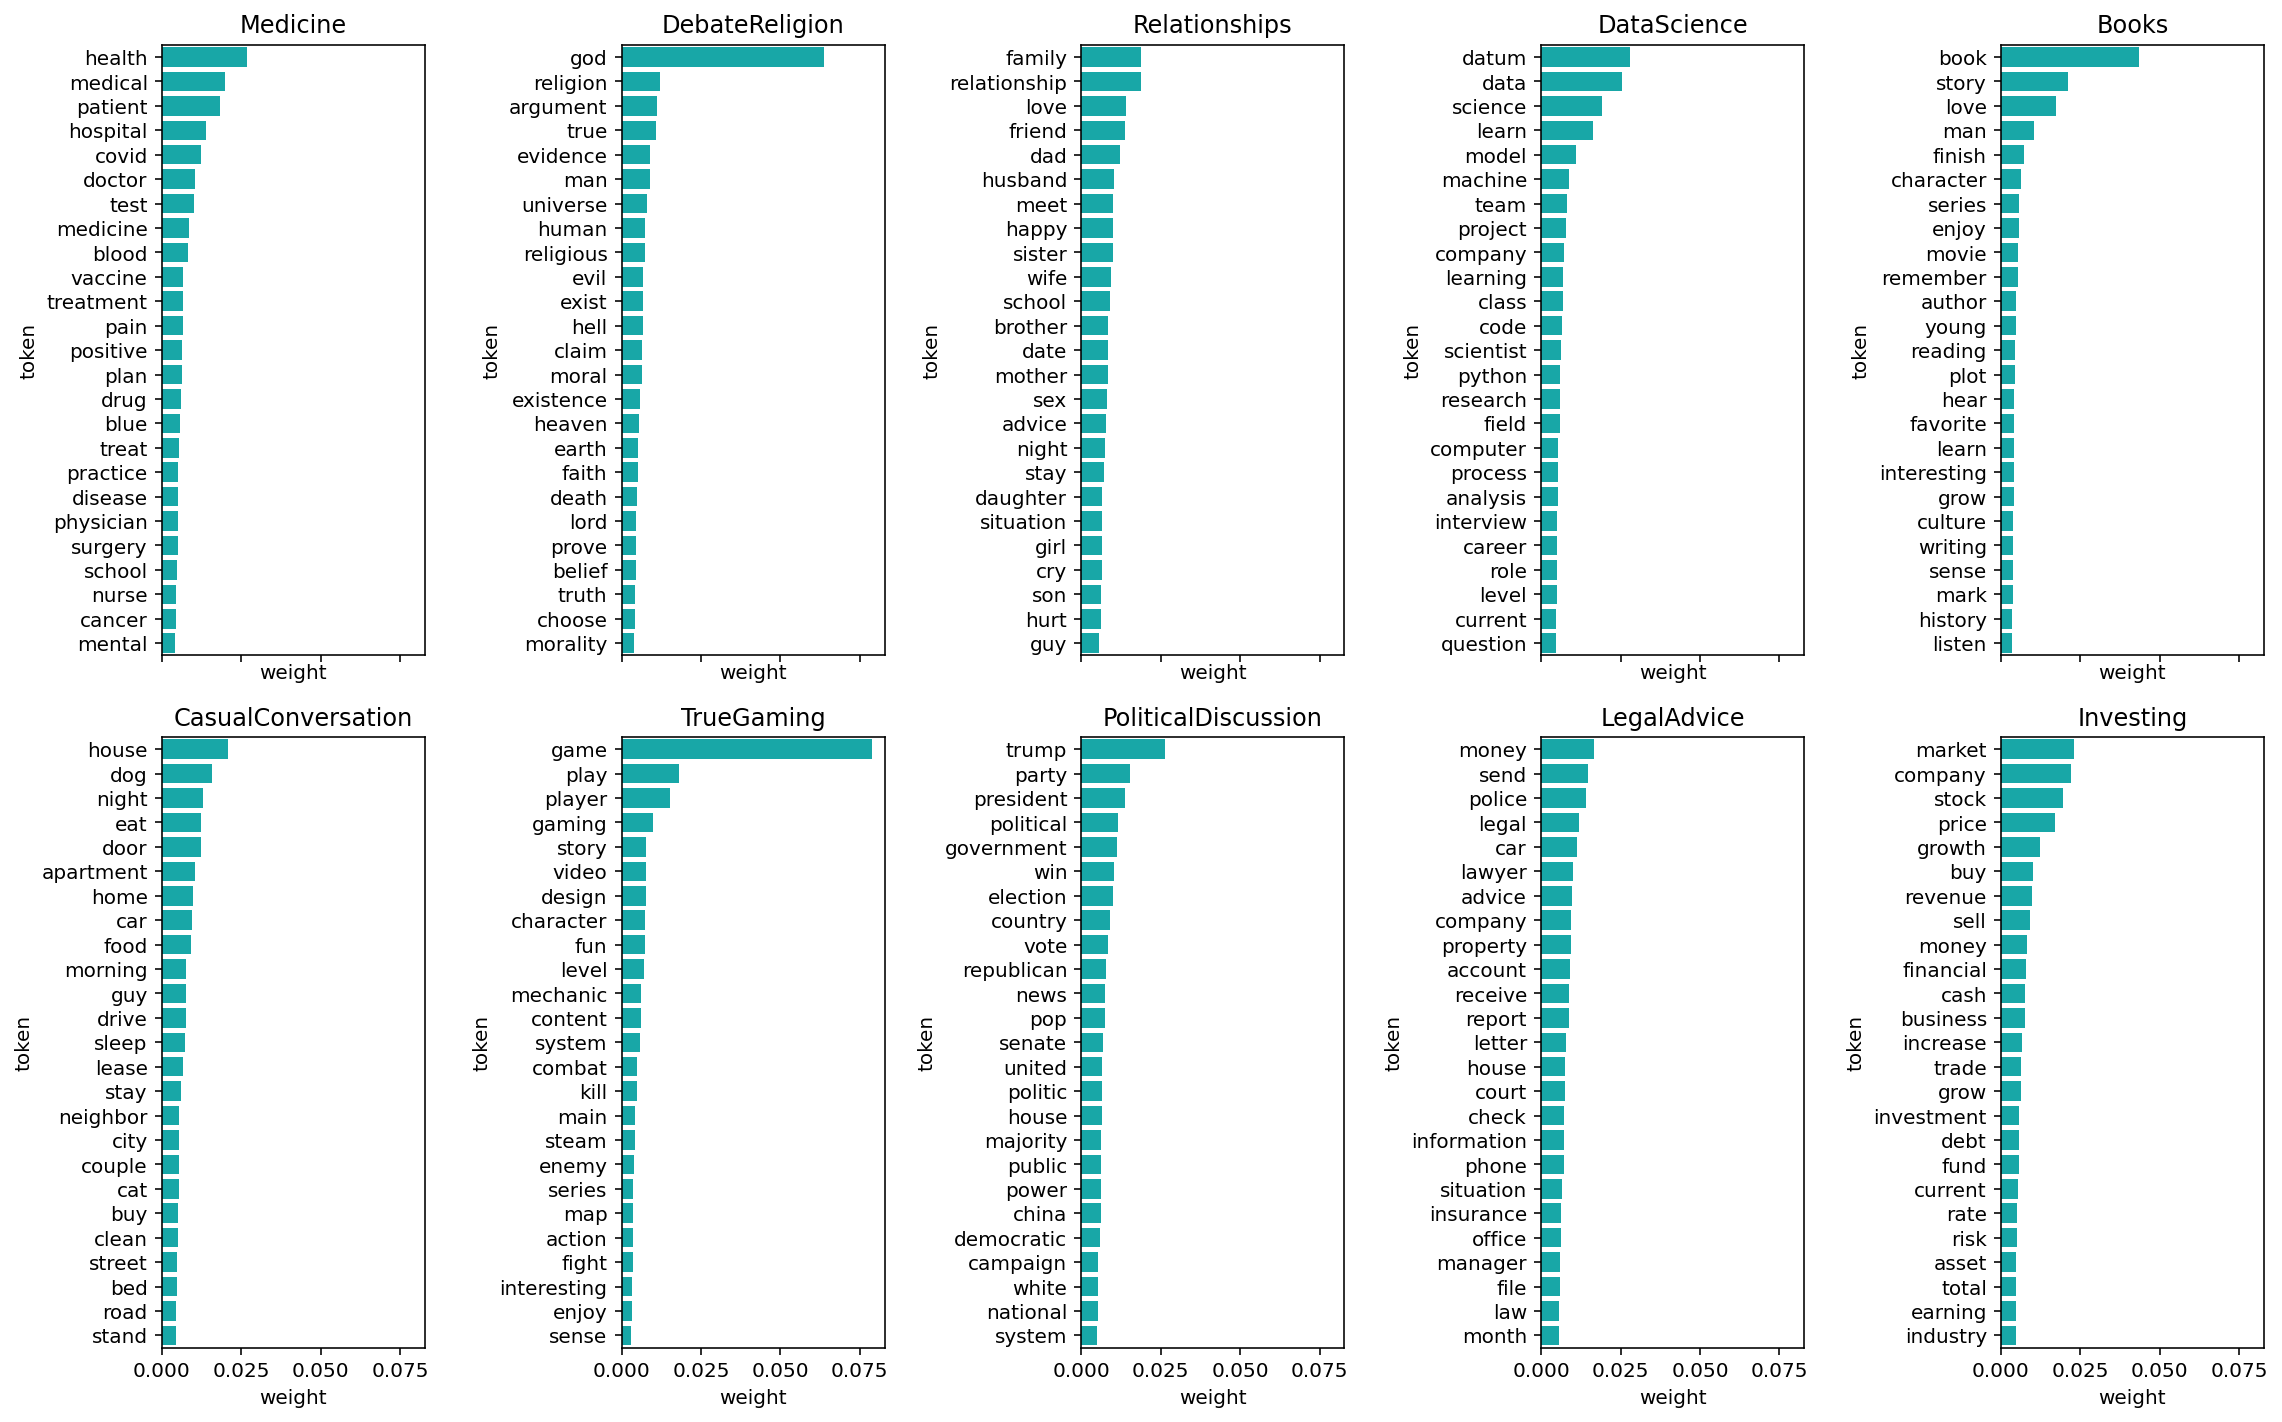

In [13]:
reddit_df_test = reddit_df.sample(frac=0.3,random_state=42)
reddit_df_train = reddit_df.loc[reddit_df.index.difference(reddit_df_test.index)]

D = gensim.corpora.Dictionary.load("https://storage.googleapis.com/enver-bucket/data/clean_gensim.dict") #We get the dictionary of tokens
my_corpus_train = [el.split() for el in reddit_df_train.clean_lemmas.tolist()] #We split the tokens per reddit post to get the corpus
mycorpus_bow_train = [D.doc2bow(doc) for doc in my_corpus_train] #We get the BoW representations
ldamallet = LdaMallet(mallet_path, corpus=mycorpus_bow_train, num_topics=10, id2word=D, alpha=5, iterations=1000,random_seed=42)
topic_names = ['Medicine','DebateReligion','Relationships','DataScience','Books','CasualConversation','TrueGaming','PoliticalDiscussion','LegalAdvice','Investing',]
for fig,ax,i in subplotted(10,ncols=5,figsize=(16,10),sharex=True):
    # Build a dataframe with columns 'token' and 'weight' for topic i
    df = pd.DataFrame(ldamallet.show_topic(i, topn=25), columns=['token','weight'])
    sns.barplot(x='weight', y='token', data=df, color='c', orient='h', ax=ax)
    ax.set_title(topic_names[i])
plt.tight_layout()
plt.show()

By inspecticng the results from the image above we can conclude that there is indeed a clear relationship between the topics obtained by the model and the subject of the subreddits that we are attempting to classify in this task. As such, we've manually assigned to each of these topics the name of the subreddit that we thing is more related to it based on their most relevant words as can be seen in the figure. 

Now all we have to do to obtain a classification is get for each document/post in the dataset the name of its most significant topic in this new LDA with 10 topics. This is done by grabbing the topic associated with the largest weight of those obtained by the LDA in each post.

In [14]:
#Get the most significant topics of each post in the test set
my_corpus_test = [el.split() for el in reddit_df_test.clean_lemmas.tolist()] #We split the tokens per reddit post to get the corpus
mycorpus_bow_test = [D.doc2bow(doc) for doc in my_corpus_test] #We get the BoW representations
ldagensim = malletmodel2ldamodel(ldamallet)

test_lda10 = [ldagensim[el] for el in mycorpus_bow_test]
reddit_df_test['LDA_10_assigned_topic'] = [topic_names[sorted(el,key=lambda x: -x[-1])[0][0]] for el in test_lda10]

#See a sample of the assigned topics
reddit_df_test[['title','subreddit','LDA_10_assigned_topic']].sample(50)

,title,subreddit,LDA_10_assigned_topic
10364,Got fired for informing company owner that his...,legaladvice,LegalAdvice
6909,Mining for car batteries . Study in link,investing,Investing
9571,"Channeling my depression, loneliness and hopel...",CasualConversation,Relationships
7142,UPDATE: I [24F] am at the end of my rope with ...,relationships,Relationships
2638,"When watching TF2 in Russian, Heavy actually s...",truegaming,Books
3550,How are in-game economies balanced?,truegaming,TrueGaming
4881,"A God that rapes human beings, and even deligh...",DebateReligion,DebateReligion
210,Why did this have to happen?,medicine,Relationships
10575,Dog went into kennel for 2 days and came out w...,legaladvice,CasualConversation
4191,Trump threatens to unseat Paul Ryan as chair o...,PoliticalDiscussion,PoliticalDiscussion


Lets see how good the topic modeling classification approach is at assigning to each post of the test set it's corresponding subreddit/topic.

In [ ]:
acc = sum(reddit_df_test.subreddit.str.lower()==reddit_df_test.LDA_10_assigned_topic.str.lower())/len(reddit_df_test)
print("Accuracy with LDA unsupervised classification: %1.2f%%"%(acc*100))

Accuracy with LDA unsupervised classification: 79.92%


Looks like a good result in hindsight. Let's see a breakdown by target label from best to worst:

In [ ]:
acc_dict = []
for subr in reddit_df_test.subreddit.unique():
  df = reddit_df_test[reddit_df_test.subreddit==subr]
  acc_dict.append({'subreddit':subr,'LDA_10_accuracy':sum(df.subreddit.str.lower()==df.LDA_10_assigned_topic.str.lower())/len(df)})
pd.DataFrame(acc_dict).round(3).sort_values('LDA_10_accuracy',ascending=False)

,subreddit,LDA_10_accuracy
1,datascience,0.972
7,DebateReligion,0.965
3,relationships,0.911
0,PoliticalDiscussion,0.902
6,truegaming,0.887
9,investing,0.872
2,books,0.859
8,medicine,0.725
4,legaladvice,0.572
5,CasualConversation,0.320


`r/CasualConversation` seems to be the most difficult to be assigned as its own topic. This is probably because the conversations and posts in this forum tend to be more general and oriented to a large and relative diverse group of people rather than a specific group that use a distinct vocabulary that can be easily differentiated from the rest as it is in the case of `r/dataScience` and `r/DebateReligion`.  

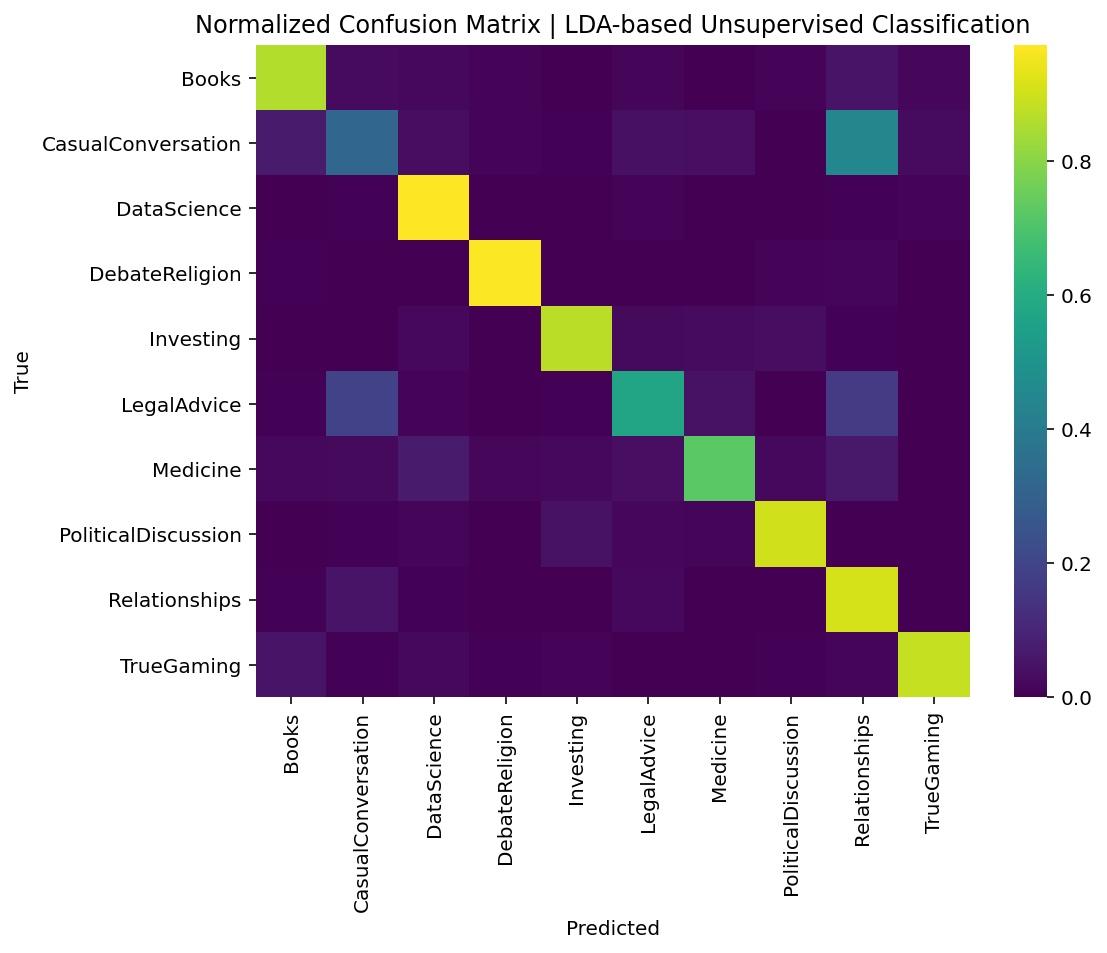

In [26]:
plt.figure(figsize=(8,6))
sns.heatmap(
  pd.DataFrame(
      confusion_matrix(
          y_true=reddit_df_test.subreddit.str.lower(),
          y_pred=reddit_df_test.LDA_10_assigned_topic.str.lower(),
          normalize="true"
          ),
      columns=sorted(topic_names), index=sorted(topic_names),
  ), cmap="viridis"
).set(title="Normalized Confusion Matrix | LDA-based Unsupervised Classification",xlabel="Predicted",ylabel="True")
plt.show()

As expected, forums with a less specialized vocabulary like *Relationships* and *CasualConversation*  tend to get mixed up by the unsupervised approach.

### 1.3 Supervised Classification based on LDA vector representation

Given that we have the true labels of each post, we are now going to consider tackling this problem using a supervised approach. We expect that the results obtained from this approach will be significanly better than the supervised approach used above.

#### 1.3.1 Model Selection and Crossvalidaiton

For this section we are going to apply the most common classification models along with it corresponding hyperparameter crossvalidation in order to get the best accuracy possible.

In order to check the efficency of each model, we are going to measure the accuracy and the time they take to classify the hole testset. Other measures like the precision or the recall are going to be printed in the classification report of each model but we are not going to take this into account. Also, we are measuring the total crossvalidation time to have a rough idea of how much time we need to spend in order to make the crossvalidation 

In [ ]:
#Creating dictionaries to store the model results and later create plots 
results_LDA = {}
crossval_time_LDA = {}
fit_time_LDA = {}

##### 1.3.1.1 K-NN 

In [ ]:
#KNN crossvalidation

k =  [1,3,5,7,10,15,20,50,100]
weight = ['distance', 'uniform']

params = dict(n_neighbors = k,weights = weight)

crossval_time = time.time()
KNN_grid = GridSearchCV(KNeighborsClassifier(),param_grid = params,n_jobs = -1, cv = 5,return_train_score = True)

KNN_grid.fit(X_train,y_train)
crossval_time = time.time() - crossval_time

print("Best accuracy achieved in CV: {0:.2f}".format(KNN_grid.best_score_))
print("Best choice of parameters {}".format(KNN_grid.best_params_))
print("Total time elapsed {}".format(crossval_time))

Best_K_LDA = KNN_grid.best_params_['n_neighbors']
Best_Distance_LDA = KNN_grid.best_params_['weights']

crossval_time_LDA["KNN"] = crossval_time

Best accuracy achieved in CV: 0.85
Best choice of parameters {'n_neighbors': 20, 'weights': 'uniform'}
Total time elapsed 38.41639685630798


In [ ]:
#KNN Predictions
KNN_predict = KNN_grid.predict(X_test)
fit_time = time.time()
test_KNN = KNN_grid.score(X_test, y_test)
fit_time = time.time() - fit_time

print(subreddit2label)
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, KNN_predict))
print("\n=== Classification Report ===")
print(classification_report(y_test, KNN_predict))
print("Accuracy of KNN : {0:.3f}".format(test_KNN))
print("Total time elapsed on fitting {}".format(fit_time))

results_LDA["KNN"]=test_KNN
fit_time_LDA["KNN"]=fit_time

{0: 'medicine', 1: 'books', 2: 'datascience', 3: 'truegaming', 4: 'PoliticalDiscussion', 5: 'DebateReligion', 6: 'investing', 7: 'relationships', 8: 'CasualConversation', 9: 'legaladvice'}

=== Confusion Matrix ===
[[189   4   7   0   4   3   4   5   3  10]
 [  0 219   1   7   2   2   0   3  20   2]
 [  3   0 204   2   0   0   4   2   2   1]
 [  1   6   9 410   2   1   2   2   1   0]
 [  6   0   1   0 288   1  16   0   0   5]
 [  1   2   0   1   5 394   0   0   2   0]
 [  8   0   5   3  17   1 242   1   2   2]
 [  3   2   3   0   0   2   1 439  27  26]
 [ 13  14   7  10   1   4   1 102 122  23]
 [ 19   1   4   1   1   0   3  38  12 398]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       229
           1       0.88      0.86      0.87       256
           2       0.85      0.94      0.89       218
           3       0.94      0.94      0.94       434
           4       0.90      0.91      0.90       31

##### 1.3.1.2 Random Forest 

In [ ]:
#RF crossvalidation

n_estimators = [10,20,50,100,200,500]
max_leaf_nodes = [5,10,20,50]

params_grid_RF = dict(n_estimators = n_estimators,max_leaf_nodes = max_leaf_nodes)

rf = RandomForestClassifier()

crossval_time = time.time() 
RF_grid = GridSearchCV(rf,params_grid_RF,return_train_score = True,cv = 5,n_jobs = -1)
RF_grid.fit(X_train,y_train)
crossval_time = time.time() - crossval_time

print("Best accuracy achieved in CV: {0:.2f}".format(RF_grid.best_score_))
print("Best choice of parameters {}".format(RF_grid.best_params_))
print("Total time elapsed {}".format(crossval_time))

Best_max_leaf_nodes_LDA = RF_grid.best_params_['max_leaf_nodes']
Best_n_estimators_LDA = RF_grid.best_params_['n_estimators']

crossval_time_LDA["RF"] = crossval_time 

Best accuracy achieved in CV: 0.85
Best choice of parameters {'max_leaf_nodes': 50, 'n_estimators': 50}
Total time elapsed 140.5093216896057


In [ ]:
#RF Predictions
rfc_predict = RF_grid.predict(X_test)

fit_time = time.time()
test_rf = RF_grid.score(X_test, y_test)
fit_time = time.time() - fit_time

print(subreddit2label)
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print("\n=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print("Accuracy of RF : {0:.3f}".format(test_rf))
print("Total time elapsed on fitting {}".format(fit_time))

results_LDA["RF"] = test_rf
fit_time_LDA["RF"] = fit_time 

{0: 'medicine', 1: 'books', 2: 'datascience', 3: 'truegaming', 4: 'PoliticalDiscussion', 5: 'DebateReligion', 6: 'investing', 7: 'relationships', 8: 'CasualConversation', 9: 'legaladvice'}

=== Confusion Matrix ===
[[189   3   8   0   3   3   5   4   6   8]
 [  1 216   0   6   2   4   0   4  19   4]
 [  0   0 203   2   0   0   4   2   4   3]
 [  0  10   8 402   1   3   1   5   3   1]
 [  3   0   2   0 289   2  13   0   0   8]
 [  2   0   0   0   0 401   1   0   1   0]
 [  7   0   2   5  14   1 245   1   2   4]
 [  5   2   3   1   0   2   1 442  24  23]
 [ 14  14   7   9   1   4   0 105 120  23]
 [ 16   1   4   1   1   0   3  35   7 409]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       229
           1       0.88      0.84      0.86       256
           2       0.86      0.93      0.89       218
           3       0.94      0.93      0.93       434
           4       0.93      0.91      0.92       31

##### 1.3.1.3 Super Vectors Machine (RBF)

In [ ]:
c = [0.01,0.1,1,10,100,1000]
gamma = [0.001,0.01,0.1,1,10,100]

params_grid_ = dict(C = c, gamma = gamma)

crossval_time = time.time() 
SVM_grid = GridSearchCV(SVC(kernel='rbf'),params_grid_,cv = 5,return_train_score = True,n_jobs = -1)
SVM_grid.fit(X_train,y_train)
crossval_time = time.time() - crossval_time

print("Best accuracy achieved in CV: {0:.2f}".format(SVM_grid.best_score_))
print("Best choice of parameters {}".format(SVM_grid.best_params_))
print("Total time elapsed {}".format(crossval_time))

Best_C_LDA = SVM_grid.best_params_['C']
Best_Gamma_LDA = SVM_grid.best_params_['gamma']

crossval_time_LDA["SVM_RBF"] = crossval_time 

Best accuracy achieved in CV: 0.86
Best choice of parameters {'C': 1000, 'gamma': 0.1}
Total time elapsed 333.9639141559601


In [ ]:
#SVM (RBF kernel) Predictions
SVM_predict = SVM_grid.predict(X_test)

fit_time = time.time() 
test_SVM = SVM_grid.score(X_test, y_test)
fit_time = time.time() - fit_time

print(subreddit2label)
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, SVM_predict))
print("\n=== Classification Report ===")
print(classification_report(y_test, SVM_predict))
print("Accuracy of SVM : {0:.3f}".format(test_SVM))
print("Total time elapsed on fitting {}".format(fit_time))

results_LDA["SVM_RBF"] = test_SVM
fit_time_LDA["SVM_RBF"] = fit_time 

{0: 'medicine', 1: 'books', 2: 'datascience', 3: 'truegaming', 4: 'PoliticalDiscussion', 5: 'DebateReligion', 6: 'investing', 7: 'relationships', 8: 'CasualConversation', 9: 'legaladvice'}

=== Confusion Matrix ===
[[190   3   4   0   3   3   5   3   8  10]
 [  2 218   1   8   2   3   1   5  14   2]
 [  5   0 201   3   0   0   3   2   3   1]
 [  1   6   8 411   3   1   2   0   2   0]
 [  8   0   1   0 287   1  16   0   0   4]
 [  1   2   0   1   6 395   0   0   0   0]
 [  6   0   5   4  15   1 247   1   2   0]
 [  2   2   1   1   0   2   1 444  24  26]
 [ 14  15   6  10   1   4   0 117 108  22]
 [ 15   2   4   1   1   0   4  34   9 407]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       229
           1       0.88      0.85      0.87       256
           2       0.87      0.92      0.90       218
           3       0.94      0.95      0.94       434
           4       0.90      0.91      0.90       31

##### 1.3.1.4 Super Vectors Machine (Linear)

In [ ]:
#SVC linear

c = [0.01,0.1,1,10,100,1000]

params_grid_ = dict(C = c)

crossval_time = time.time() 
SVM_linear_grid = GridSearchCV(SVC(kernel='linear'),params_grid_,cv = 5,return_train_score = True,n_jobs = -1)
SVM_linear_grid.fit(X_train,y_train)
crossval_time = time.time() - crossval_time

print("Best accuracy achieved in CV: {0:.2f}".format(SVM_linear_grid.best_score_))
print("Best choice of parameters {}".format(SVM_linear_grid.best_params_))
print("Total time elapsed {}".format(crossval_time))

Best_C_linear_LDA = SVM_linear_grid.best_params_['C']

crossval_time_LDA["SVM_Linear"] = crossval_time 

Best accuracy achieved in CV: 0.86
Best choice of parameters {'C': 1000}
Total time elapsed 22.08936047554016


In [ ]:
#SVM (Linear kernel) Predictions
SVM_linear_predict = SVM_linear_grid.predict(X_test)

fit_time = time.time() 
test_SVM_linear = SVM_linear_grid.score(X_test, y_test)
fit_time = time.time() - fit_time

print(subreddit2label)
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, SVM_linear_predict))
print("\n=== Classification Report ===")
print(classification_report(y_test, SVM_linear_predict))
print("Accuracy of Linear SVM : {0:.3f}".format(test_SVM_linear))
print("Total time elapsed on fitting {}".format(fit_time))

results_LDA["SVM_Linear"] = test_SVM_linear
fit_time_LDA["SVM_Linear"] = fit_time 

{0: 'medicine', 1: 'books', 2: 'datascience', 3: 'truegaming', 4: 'PoliticalDiscussion', 5: 'DebateReligion', 6: 'investing', 7: 'relationships', 8: 'CasualConversation', 9: 'legaladvice'}

=== Confusion Matrix ===
[[189   3   4   0   4   2   6   2   9  10]
 [  1 214   1   8   2   4   1   3  21   1]
 [  5   0 199   3   1   0   4   2   3   1]
 [  1   5   8 410   3   2   2   0   3   0]
 [  4   0   1   0 291   1  15   0   0   5]
 [  1   2   0   1   4 397   0   0   0   0]
 [  8   0   5   4  14   1 246   0   3   0]
 [  2   2   1   3   0   2   1 433  33  26]
 [ 14  11   6  10   1   4   0  96 136  19]
 [ 17   2   4   1   1   0   5  30  14 403]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       229
           1       0.90      0.84      0.86       256
           2       0.87      0.91      0.89       218
           3       0.93      0.94      0.94       434
           4       0.91      0.92      0.91       31

##### 1.3.1.5 Super Vectors Machine (Polynomial)

In [ ]:
# SVC polynomial

c = [0.01,0.1,1,10,100,1000]
degree = np.arange(2,6)

params = dict(C = c,degree = degree)

crossval_time = time.time()
SVC_polynomial = GridSearchCV(SVC(kernel = 'poly'),params,cv = 5,n_jobs = -1)
SVC_polynomial.fit(X_train,y_train)
crossval_time = time.time() - crossval_time

print("Best accuracy achieved in CV: {0:.2f}".format(SVC_polynomial.best_score_))
print("Best choice of parameters {}".format(SVC_polynomial.best_params_))
print("Total time elapsed {}".format(crossval_time))

Best_C_polynomial_LDA = SVC_polynomial.best_params_['C']
Best_Degree_LDA = SVC_polynomial.best_params_['degree']

crossval_time_LDA["SVM_Poly"] = crossval_time 

Best accuracy achieved in CV: 0.86
Best choice of parameters {'C': 1, 'degree': 4}
Total time elapsed 131.31937170028687


In [ ]:
#SVM (Polinomial kernel) Predictions
SVM_polynomial_predict = SVC_polynomial.predict(X_test)

fit_time = time.time() 
test_SVM_polynomial = SVC_polynomial.score(X_test, y_test)
fit_time = time.time() - fit_time

print(subreddit2label)
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, SVM_polynomial_predict))
print("\n=== Classification Report ===")
print(classification_report(y_test, SVM_polynomial_predict))
print("Accuracy of Polinomial SVM : {0:.3f}".format(test_SVM_polynomial))
print("Total time elapsed on fitting {}".format(fit_time))

results_LDA["SVM_Poly"] = test_SVM_polynomial
fit_time_LDA["SVM_Poly"] = fit_time 

{0: 'medicine', 1: 'books', 2: 'datascience', 3: 'truegaming', 4: 'PoliticalDiscussion', 5: 'DebateReligion', 6: 'investing', 7: 'relationships', 8: 'CasualConversation', 9: 'legaladvice'}

=== Confusion Matrix ===
[[195   3   4   0   3   3   5   2   4  10]
 [  1 215   0   7   2   2   1   1  25   2]
 [  5   1 198   3   1   0   4   2   3   1]
 [  1   6   6 412   3   1   1   0   4   0]
 [  9   0   1   0 287   1  14   0   0   5]
 [  2   2   0   1   6 394   0   0   0   0]
 [  5   0   5   6  15   1 243   1   3   2]
 [  3   2   1   0   0   2   0 432  34  29]
 [ 14  13   7  10   1   4   0  99 121  28]
 [ 16   1   3   1   1   0   4  33   9 409]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       229
           1       0.88      0.84      0.86       256
           2       0.88      0.91      0.89       218
           3       0.94      0.95      0.94       434
           4       0.90      0.91      0.90       31

#### 1.3.2 Analyzing the Results

In [ ]:
#Load saved results in order to plot without doing the crossvalidation
"""
results_LDA = pd.read_pickle(r"https://storage.googleapis.com/enver-bucket/data/crossval_dictio/LDA_results.pickle")
LDA_crossval = pd.read_pickle(r"https://storage.googleapis.com/enver-bucket/data/crossval_dictio/LDA_crossval.pickle")
fit_time_LDA = pd.read_pickle(r"https://storage.googleapis.com/enver-bucket/data/crossval_dictio/LDA_fit_time.pickle")

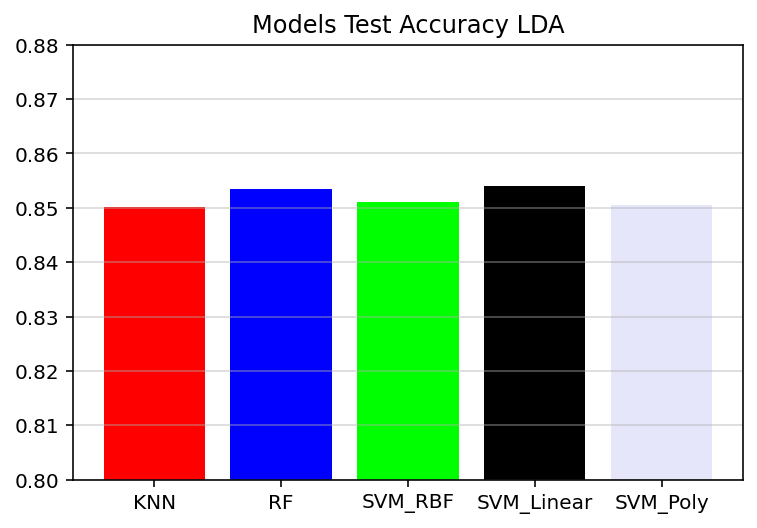

In [ ]:
plt.bar(range(len(results_LDA)), list(results_LDA.values()), align='center',color=['red', 'blue', 'lime', 'black', 'lavender'])
plt.xticks(range(len(results_LDA)), list(results_LDA.keys()))
plt.ylim((0.8,0.88))
plt.grid(alpha=0.5,axis="y")
plt.title("Models Test Accuracy LDA")

plt.show()

With this graph, we can observe that more or less with the LDA representation all the models get around a 85% of accuracy being the most difficult topic to predict the "Casual conversation" one that is being confuse with "relationships" which make sense at this topics have lot of semantical relation with each other. As we have only 10 variables (a vector of 10 for each observation) the models are more dependent on how well this vectors are than in which hyperparameters we put on them.

These results are still significantly better overall than the unsupervised approach also based on LDA.

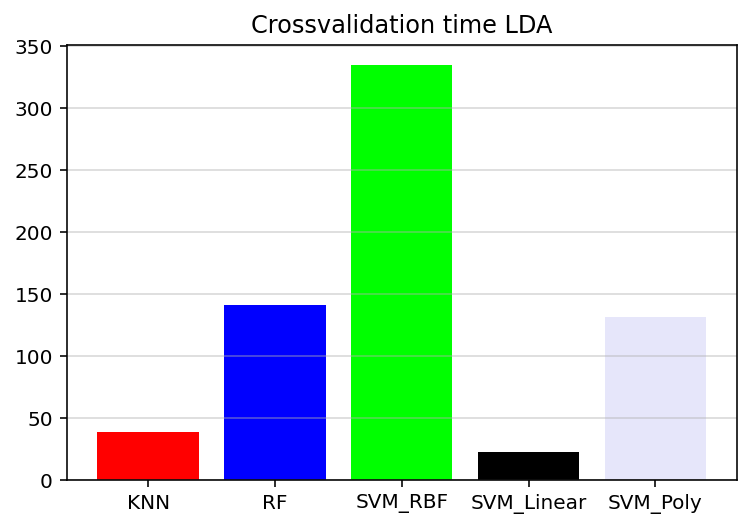

In [ ]:
plt.bar(range(len(crossval_time_LDA)), list(crossval_time_LDA.values()), align='center',color=['red', 'blue', 'lime', 'black', 'lavender'])
plt.xticks(range(len(crossval_time_LDA)), list(crossval_time_LDA.keys()))
plt.grid(alpha=0.5,axis="y")
plt.title("Crossvalidation time LDA")

plt.show()

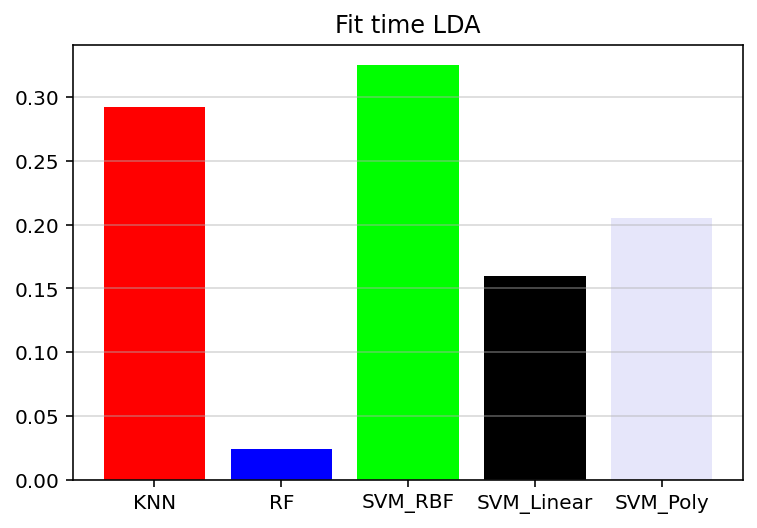

In [ ]:
plt.bar(range(len(fit_time_LDA)), list(fit_time_LDA.values()), align='center',color=['red', 'blue', 'lime', 'black', 'lavender'])
plt.xticks(range(len(fit_time_LDA)), list(fit_time_LDA.keys()))
plt.grid(alpha=0.5,axis="y")
plt.title("Fit time LDA")

plt.show()

Here we can see that all the models are practically instantaneus as the LDA only has 10 variables one for each topic making the models to learn and fit fast.

##2. TFIDF representation 

Now we are going to get the TFIDF representation which from the classification point of view is much more interesting as now we have one variable per token, making a total of more than 9000 variables. On the other hand this increase on the variables also means that we are going to need more computational power and time.

In [ ]:
D = gensim.corpora.Dictionary.load("https://storage.googleapis.com/enver-bucket/data/clean_gensim.dict") #We get the dictionary of tokens
my_corpus = reddit_df.clean_lemmas.tolist() #We get the clean lemmas sotred on the df
my_corpus = [el.split() for el in my_corpus] #We split the tokens per reddit post
bow = [D.doc2bow(doc) for doc in my_corpus] #We get the BoW representations
tfidf = TfidfModel(bow) #We create the tfidf vector representation
reddit_df["TF-IDF"] = tfidf[bow] #We add this vector to the dataframe

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
dictio_list_TFIDF = list2dict(reddit_df['TF-IDF']) #We get the dictionary from the list of vectors

In [ ]:
TFIDF_df = pd.DataFrame(dictio_list_TFIDF) #We create the new dataframe with the new dictionary
TFIDF_df.fillna(0,inplace=True) #We fill the nans with 0 as the vectors were sparse
TFIDF_df["subreddit"] = reddit_df['subreddit'] #We add the subreditt column to later labelize it
TFIDF_df["labels"] = int(0) 

subreddit2label = labelizer(TFIDF_df) #We labelize the variables

TFIDF_df.drop("subreddit",inplace=True,axis=1)


In [ ]:
TFIDF_df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9452,9453,9454,9456,9457,9458,9459,9460,9461,9462,9463,9465,9466,9467,9468,9469,9470,9471,9472,9474,9475,9476,9477,9479,9481,9482,9484,9486,9487,9490,9492,9493,9494,9495,9496,9497,9498,9499,9500,labels
0,0.029819,0.024120,0.022755,0.057043,0.034397,0.024864,0.041535,0.04119,0.049288,0.049168,0.030115,0.040545,0.031127,0.066091,0.050822,0.03299,0.05596,0.023537,0.173290,0.036396,0.066664,0.087101,0.032824,0.017708,0.039015,0.084233,0.030385,0.023584,0.057166,0.109359,0.038648,0.043101,0.028833,0.053231,0.572764,0.034264,0.022111,0.019487,0.036575,0.026032,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.109131,0.000000,0.000000,0.000000,0.000000,0.061999,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.058514,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.000000,0.000000,0.051336,0.000000,0.000000,0.028047,0.000000,0.00000,0.000000,0.110924,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048619,0.000000,0.000000,0.025844,0.000000,0.000000,0.021982,0.041257,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.067945,0.000000,0.000000,0.055893,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.091899,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.048920,0.000000,0.000000,0.030481,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.059264,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055095,0.082397,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.059633,0.000000,0.036436,0.000000,0.000000,0.039982,0.000000,0.00000,0.00000,0.028478,0.000000,0.000000,0.120985,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052148,0.000000,0.021468,0.055439,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
7,0.000000,0.059463,0.000000,0.04687

In [ ]:
#Splitting the dataset into train and test

X = TFIDF_df.drop("labels",axis=1)
y = TFIDF_df["labels"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 2.1 Data Visualization using Dimensionality Reduction Techniques

As with the LDA, we can visualize the new data applying some PCA. This time we cannot use FDA as it is supervised and it takes too much time to compute

{0: 'medicine', 1: 'books', 2: 'datascience', 3: 'truegaming', 4: 'PoliticalDiscussion', 5: 'DebateReligion', 6: 'investing', 7: 'relationships', 8: 'CasualConversation', 9: 'legaladvice'}


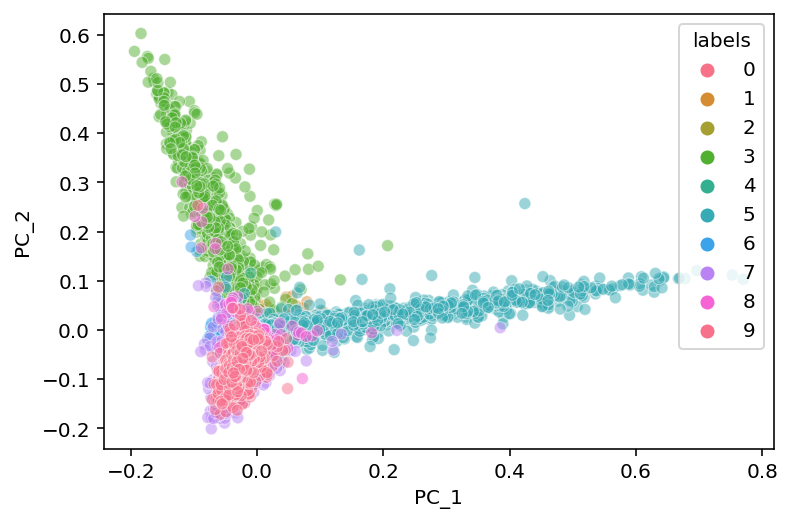

In [ ]:
my_pca = PCA(n_components=2).fit(X)
P_data = my_pca.transform(X)
PCA_df = pd.DataFrame(P_data)
dictio = {0: 'PC_1',1: 'PC_2'}
PCA_df.rename(columns=dictio,inplace=True)

sns.scatterplot(x=PCA_df["PC_1"],y=PCA_df["PC_2"],hue=y,palette="husl",legend="full",alpha=0.5,)
print(subreddit2label)

### 2.2 Model Selection and Crossvalidaiton

As with the LDA we are going to use the same methodology to get the best models. This time as we have many varibles, we are going to first project the data into a smaller space using PCA to make the crossvalidation time lower. We have choose 200 components although the explained variable is low because after making some tests, the accuracy didn't vary much from this point but the time is considerably reduced. Less than 200 components affect very negatively to the accuracy too. 

In [ ]:
#We create another dictionarys to store the results
results_TFIDF = {}
crossval_time_TFIDF = {}
fit_time_TFIDF = {}

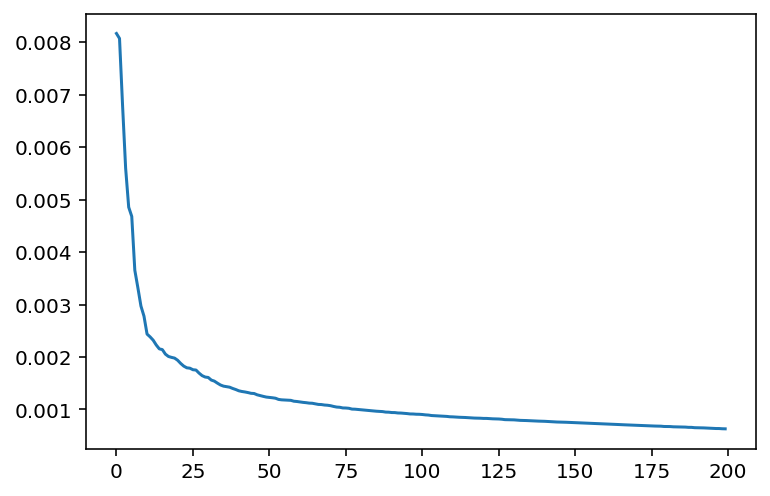

Total variance explain: 0.24561134133372922


In [ ]:
my_pca = PCA(n_components=200).fit(X_train) #Here we project the data into a 200 dimension space
X_train = my_pca.transform(X_train)
X_test = my_pca.transform(X_test)
eigenvalues = my_pca.explained_variance_
plt.figure()
plt.plot(eigenvalues, label='Evolution eigenvalues')
plt.show()
print("Total variance explain: " + str(sum(eigenvalues)))

#### 2.2.1 K-NN 

In [ ]:
#KNN crossvalidation

k =  [1,3,5,7,10,15,20,50,100]
weight = ['distance', 'uniform']

params = dict(n_neighbors = k,weights = weight)

crossval_time = time.time() 
KNN_grid = GridSearchCV(KNeighborsClassifier(),param_grid = params,n_jobs = -1, cv = 5,return_train_score = True)
KNN_grid.fit(X_train,y_train)
crossval_time = time.time() - crossval_time

print("Best accuracy achieved in CV: {0:.2f}".format(KNN_grid.best_score_))
print("Best choice of parameters {}".format(KNN_grid.best_params_))
print("Total time elapsed {}".format(crossval_time))

Best_K_TFIDF = KNN_grid.best_params_['n_neighbors']
Best_Distance_TFIDF = KNN_grid.best_params_['weights']

crossval_time_TFIDF["KNN"] = crossval_time

Best accuracy achieved in CV: 0.80
Best choice of parameters {'n_neighbors': 50, 'weights': 'distance'}
Total time elapsed 977.6311721801758


In [ ]:
#KNN Predictions
KNN_predict = KNN_grid.predict(X_test)
fit_time = time.time()
test_KNN = KNN_grid.score(X_test, y_test)
fit_time = time.time() - fit_time


print(subreddit2label)
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, KNN_predict))
print("\n=== Classification Report ===")
print(classification_report(y_test, KNN_predict))
print("Accuracy of KNN : {0:.3f}".format(test_KNN))
print("Total time elapsed on fitting {}".format(fit_time))

results_TFIDF["KNN"] = test_KNN
fit_time_TFIDF["KNN"] = fit_time

{0: 'medicine', 1: 'books', 2: 'datascience', 3: 'truegaming', 4: 'PoliticalDiscussion', 5: 'DebateReligion', 6: 'investing', 7: 'relationships', 8: 'CasualConversation', 9: 'legaladvice'}

=== Confusion Matrix ===
[[196   1   0   0   3   2   4   1  21   1]
 [  1 217   1   3   2   6   2   0  23   1]
 [  3   1 184   4   0   1   9   0  15   1]
 [  4   4   1 410   2   2   3   0   6   2]
 [ 12   0   0   1 279   4  14   0   4   3]
 [  2   7   0   0   1 383   1   3   7   1]
 [  9   1   2   3  13   1 247   0   3   2]
 [ 10   3   0   3   2   3   3 283 175  21]
 [ 11   6   2  10   4   3   2  19 225  15]
 [ 30   1   1   2   5   2  10  35  88 303]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.71      0.86      0.77       229
           1       0.90      0.85      0.87       256
           2       0.96      0.84      0.90       218
           3       0.94      0.94      0.94       434
           4       0.90      0.88      0.89       31

#### 2.2.2 Random Forest 

In [ ]:
#RF crossvalidation

n_estimators = [10,20,50,100,200,500]
max_leaf_nodes = [5,10,20,50]

params_grid_RF = dict(n_estimators = n_estimators,max_leaf_nodes = max_leaf_nodes)

rf = RandomForestClassifier()

crossval_time = time.time() 
RF_grid = GridSearchCV(rf,params_grid_RF,return_train_score = True,cv = 5,n_jobs = -1)
RF_grid.fit(X_train,y_train)
crossval_time = time.time() - crossval_time

print("Best accuracy achieved in CV: {0:.2f}".format(RF_grid.best_score_))
print("Best choice of parameters {}".format(RF_grid.best_params_))
print("Total time elapsed {}".format(crossval_time))

Best_max_leaf_nodes_TFIDF = RF_grid.best_params_['max_leaf_nodes']
Best_n_estimators_TFIDF = RF_grid.best_params_['n_estimators']

crossval_time_TFIDF["RF"] = crossval_time

Best accuracy achieved in CV: 0.85
Best choice of parameters {'max_leaf_nodes': 50, 'n_estimators': 100}
Total time elapsed 578.4987969398499


In [ ]:
#RF Predictions
rfc_predict = RF_grid.predict(X_test)
fit_time = time.time()
test_rf = RF_grid.score(X_test, y_test)
fit_time = time.time() - fit_time

print(subreddit2label)
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print("\n=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print("Accuracy of RF : {0:.3f}".format(test_rf))
print("Total time elapsed on fitting {}".format(fit_time))

results_TFIDF["RF"] = test_rf
fit_time_TFIDF["RF"] = fit_time

{0: 'medicine', 1: 'books', 2: 'datascience', 3: 'truegaming', 4: 'PoliticalDiscussion', 5: 'DebateReligion', 6: 'investing', 7: 'relationships', 8: 'CasualConversation', 9: 'legaladvice'}

=== Confusion Matrix ===
[[185   3   3   0   5   4   4   8   7  10]
 [  0 221   0   6   0   9   1   4  11   4]
 [  1   1 201   3   1   1   2   2   1   5]
 [  1   4   3 409   0   2   6   1   4   4]
 [  4   0   0   1 291   6   6   1   0   8]
 [  1   6   0   1   5 382   0   6   4   0]
 [  5   1   6   2  16   1 242   0   0   8]
 [  1   4   0   0   0   1   0 443  17  37]
 [  7   6   1  10   4   9   3 101 121  35]
 [ 18   0   2   3   1   1   6  53   8 385]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       229
           1       0.90      0.86      0.88       256
           2       0.93      0.92      0.93       218
           3       0.94      0.94      0.94       434
           4       0.90      0.92      0.91       31

#### 2.2.3 Super Vectors Machine (RBF)

In [ ]:
c = [0.1,1,10,100,1000]
gamma = [0.001,0.01,0.1,1,10]

params_grid_ = dict(C = c, gamma = gamma)

crossval_time = time.time() 
SVM_grid = GridSearchCV(SVC(kernel='rbf'),params_grid_,cv = 5,return_train_score = True,n_jobs = -1)
SVM_grid.fit(X_train,y_train)
crossval_time = time.time() - crossval_time

print("Best accuracy achieved in CV: {0:.2f}".format(SVM_grid.best_score_))
print("Best choice of parameters {}".format(SVM_grid.best_params_))
print("Total time elapsed {}".format(crossval_time))

Best_C_TFIDF = SVM_grid.best_params_['C']
Best_Gamma_TFIDF = SVM_grid.best_params_['gamma']

crossval_time_TFIDF["SVM_RBF"] = crossval_time

Best accuracy achieved in CV: 0.90
Best choice of parameters {'C': 10, 'gamma': 1}
Total time elapsed 1495.9832909107208


In [ ]:
#SVM (RBF kernel) Predictions
SVM_predict = SVM_grid.predict(X_test)
fit_time = time.time() 
test_SVM = SVM_grid.score(X_test, y_test)
fit_time = time.time() - fit_time

print(subreddit2label)
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, SVM_predict))
print("\n=== Classification Report ===")
print(classification_report(y_test, SVM_predict))
print("Accuracy of SVM : {0:.3f}".format(test_SVM))
print("Total time elapsed on fitting {}".format(fit_time))

results_TFIDF["SVM_RBF"] = test_SVM
fit_time_TFIDF["SVM_RBF"] = fit_time

{0: 'medicine', 1: 'books', 2: 'datascience', 3: 'truegaming', 4: 'PoliticalDiscussion', 5: 'DebateReligion', 6: 'investing', 7: 'relationships', 8: 'CasualConversation', 9: 'legaladvice'}

=== Confusion Matrix ===
[[206   3   0   0   4   3   2   1   4   6]
 [  1 231   0   4   2   5   0   0   9   4]
 [  4   0 206   1   0   1   1   0   3   2]
 [  1   5   3 419   1   1   2   0   2   0]
 [  6   0   0   0 296   4   8   0   2   1]
 [  2   3   0   1   3 394   0   2   0   0]
 [  7   1   2   1  14   1 254   0   0   1]
 [  1   1   0   1   0   1   0 454  19  26]
 [  7   7   5   7   2   3   2  42 208  14]
 [ 13   1   3   0   1   2   3  25   8 421]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       229
           1       0.92      0.90      0.91       256
           2       0.94      0.94      0.94       218
           3       0.97      0.97      0.97       434
           4       0.92      0.93      0.93       31

#### 2.2.4 Super Vectors Machine (Linear)

In [ ]:
#SVC linear

c = [0.01,0.1,1,10,100,1000]

params_grid_ = dict(C = c)

crossval_time = time.time() 
SVM_linear_grid = GridSearchCV(SVC(kernel='linear'),params_grid_,cv = 5,return_train_score = True,n_jobs = -1)
SVM_linear_grid.fit(X_train,y_train)
crossval_time = time.time() - crossval_time

print("Best accuracy achieved in CV: {0:.2f}".format(SVM_linear_grid.best_score_))
print("Best choice of parameters {}".format(SVM_linear_grid.best_params_))
print("Total time elapsed {}".format(crossval_time))

Best_C_linear_TFIDF = SVM_linear_grid.best_params_['C']

crossval_time_TFIDF["SVM_Linear"] = crossval_time

Best accuracy achieved in CV: 0.90
Best choice of parameters {'C': 10}
Total time elapsed 250.92313933372498


In [ ]:
#SVM (Linear kernel) Predictions
SVM_linear_predict = SVM_linear_grid.predict(X_test)
fit_time = time.time() 
test_SVM_linear = SVM_linear_grid.score(X_test, y_test)
fit_time = time.time() - fit_time

print(subreddit2label)
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, SVM_linear_predict))
print("\n=== Classification Report ===")
print(classification_report(y_test, SVM_linear_predict))
print("Accuracy of Linear SVM : {0:.3f}".format(test_SVM_linear))
print("Total time elapsed on fitting {}".format(fit_time))

results_TFIDF["SVM_Linear"] = test_SVM_linear
fit_time_TFIDF["SVM_Linear"] = fit_time

{0: 'medicine', 1: 'books', 2: 'datascience', 3: 'truegaming', 4: 'PoliticalDiscussion', 5: 'DebateReligion', 6: 'investing', 7: 'relationships', 8: 'CasualConversation', 9: 'legaladvice'}

=== Confusion Matrix ===
[[203   2   0   0   2   4   2   1   8   7]
 [  0 231   0   3   2   5   0   1  12   2]
 [  3   0 207   1   0   0   1   0   4   2]
 [  1   5   3 419   1   1   2   1   1   0]
 [  5   0   0   0 300   5   4   0   2   1]
 [  1   5   0   1   3 394   0   1   0   0]
 [  7   1   2   1  15   1 252   0   0   2]
 [  1   0   0   1   0   1   0 455  23  22]
 [  5   4   4   8   2   3   2  40 213  16]
 [ 13   1   3   0   1   1   3  27   8 420]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       229
           1       0.93      0.90      0.91       256
           2       0.95      0.95      0.95       218
           3       0.97      0.97      0.97       434
           4       0.92      0.95      0.93       31

#### 2.2.5 Super Vectors Machine (Polynomial)

In [ ]:
# SVC polynomial

c = [0.01,0.1,1,10,100,1000]
degree = np.arange(2,6)

params = dict(C = c,degree = degree)

crossval_time = time.time() 
SVC_polynomial = GridSearchCV(SVC(kernel = 'poly'),params,cv = 5,n_jobs = -1)
SVC_polynomial.fit(X_train,y_train)
crossval_time = time.time() - crossval_time

print("Best accuracy achieved in CV: {0:.2f}".format(SVC_polynomial.best_score_))
print("Best choice of parameters {}".format(SVC_polynomial.best_params_))
print("Total time elapsed {}".format(crossval_time))

Best_C_polynomial_TFIDF = SVC_polynomial.best_params_['C']
Best_Degree_TFIDF = SVC_polynomial.best_params_['degree']

crossval_time_TFIDF["SVM_Poly"] = crossval_time

Best accuracy achieved in CV: 0.87
Best choice of parameters {'C': 10, 'degree': 2}
Total time elapsed 1058.1815843582153


In [ ]:
#SVM (Polinomial kernel) Predictions
SVM_polynomial_predict = SVC_polynomial.predict(X_test)
fit_time = time.time() 
test_SVM_polynomial = SVC_polynomial.score(X_test, y_test)
fit_time = time.time() - fit_time

print(subreddit2label)
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, SVM_polynomial_predict))
print("\n=== Classification Report ===")
print(classification_report(y_test, SVM_polynomial_predict))
print("Accuracy of Polinomial SVM : {0:.3f}".format(test_SVM_polynomial))
print("Total time elapsed on fitting {}".format(fit_time))

results_TFIDF["SVM_Poly"] = test_SVM_polynomial
fit_time_TFIDF["SVM_Poly"] = fit_time

{0: 'medicine', 1: 'books', 2: 'datascience', 3: 'truegaming', 4: 'PoliticalDiscussion', 5: 'DebateReligion', 6: 'investing', 7: 'relationships', 8: 'CasualConversation', 9: 'legaladvice'}

=== Confusion Matrix ===
[[188   2   0   0   3   3   2   1  25   5]
 [  1 220   0   2   2   3   0   0  27   1]
 [  4   0 194   2   0   0   0   0  13   5]
 [  1   4   1 412   1   1   4   0   8   2]
 [  5   1   0   2 293   3   8   0   3   2]
 [  0   4   0   1   2 389   0   3   6   0]
 [  6   1   2   2  10   1 251   0   6   2]
 [  1   1   0   1   0   1   1 411  59  28]
 [  5   6   4   6   1   3   1  38 214  19]
 [ 15   0   4   1   2   1   3  35  27 389]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.83      0.82      0.83       229
           1       0.92      0.86      0.89       256
           2       0.95      0.89      0.92       218
           3       0.96      0.95      0.95       434
           4       0.93      0.92      0.93       31

### 2.3 Implementing a MLP for Classification

For this TFIDF representation we wanted to use our knowledge obtained on our Neural Networks Course to make a simple MLP classifier to compare with the more classical models. MLP's are very good at handling high dimensional datasets but also are very susceptible to overfit quite well. As we have more variables than observations, the MLP is going to overfitt for sure but by applying some regularization tricks like dropout or early stopping we have got pretty decent accuracy on the test set. With a larger dataset, we are sure that this model would perform even better but the current results are also good enough for this project. 

In [ ]:
#Implementing train-test-val-split for the NN
train, test = train_test_split(TFIDF_df, test_size=0.2, random_state=42)
train, val =  train_test_split(train, test_size=0.2, random_state=42)

#To apply the early sttoping regularization to the MLP we need to also split the trainset into a validation set.

In order to make the batch normalization easier, we need to create a object that transforms the pandas data frames into a dataloader

In [ ]:
class PytorchDataset(Dataset):

    def __init__(self,Dataset):

      self.x = torch.from_numpy(Dataset.loc[:,Dataset.columns!="labels"].to_numpy(dtype=np.float32))
      self.y = torch.from_numpy(Dataset["labels"].to_numpy(dtype=np.long))

    def __getitem__(self,index):

        return self.x[index], self.y[index]

    def __len__(self):
        return len(self.x)


In [ ]:
#We transform the diferent sets into dataloaders
trainloader = torch.utils.data.DataLoader(PytorchDataset(train), batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(PytorchDataset(test), batch_size=32, shuffle=True)
validloader = torch.utils.data.DataLoader(PytorchDataset(val), batch_size=32, shuffle=True)

In [ ]:
#We create the MLP layout

class MLP(nn.Module):
  def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,dprob): 
    super().__init__()
    self.output1 = nn.Linear(dimx,hidden1)
    self.output2 = nn.Linear(hidden1,hidden2)
    self.output3 = nn.Linear(hidden2,hidden3)
    self.output4 = nn.Linear(hidden3,nlabels)
    self.relu = nn.ReLU()
    self.logsoftmax = nn.LogSoftmax(dim=1)    
    self.dropout = nn.Dropout(p=dprob)                                                         
      
  def forward(self, x):
    x = self.output1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.output2(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.output3(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.output4(x)
    x = self.logsoftmax(x)
    return x

In [ ]:
#We extend the MLP layaout class to implement the rest of the methods use
class MLP_extended(MLP):

  def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=100,dprob=0.2,lr=0.001,print_every=10):
    
    super().__init__(dimx,hidden1,hidden2,hidden3,nlabels,dprob)  
    
    self.lr = lr #Learning Rate
    
    self.optim = optim.Adam(self.parameters(), self.lr)

    self.print = print_every
    
    self.epochs = epochs
    
    self.criterion = nn.NLLLoss() 
    
    # A list to store the loss evolution along training
    
    self.loss_during_training = []
    
    # A list to store the loss evolution along validation

    self.valid_loss_during_training = []

    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.to(self.device)
      
  def trainloop(self,trainloader,validloader):
      
    # Optimization Loop

    total_time = time.time()
    
    for e in range(int(self.epochs)):

      start_time = time.time()
        
        # Random data permutation at each epoch
        
      running_loss = 0.
      running_loss_val = 0.
      
      for vectors, labels in trainloader:

        # Move input and label tensors to the default device
        vectors, labels = vectors.to(self.device), labels.to(self.device)

        self.optim.zero_grad()  #Reset gradients
    
        out = self.forward(vectors)

        loss = self.criterion(out, labels)
        running_loss += loss.item()

        loss.backward()
        self.optim.step()

      self.loss_during_training.append(running_loss/len(trainloader))

      with torch.no_grad():
        for vectors, labels in validloader:

          vectors, labels = vectors.to(self.device), labels.to(self.device)

          out = self.forward(vectors)
          loss = self.criterion(out, labels)
          running_loss_val += loss.item()                   

        self.valid_loss_during_training.append(running_loss_val/len(validloader))

      if(self.print != 0):
        if(e % self.print == 0 and self.print!=0): # Every 10 epochs (by default)

          print("Training loss after epoch %d: %f,  Time per epoch: %f seconds" 
                %(e,self.loss_during_training[-1],(time.time() - start_time))) 
          print("Validation loss after epoch %d: %f,  Time per epoch: %f seconds" 
                %(e,self.valid_loss_during_training[-1],(time.time() - start_time))) 
          
    if(self.print != 0):    
      print("\nTotal time elapsed: %f seconds" %(time.time()- total_time))

  def eval_performance(self,loader):
    loss = 0
    accuracy = 0

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():

      for vectors,labels in loader:
          
          vectors, labels = vectors.to(self.device), labels.to(self.device)
          probs = self.forward(vectors) 
          
          top_p, top_class = probs.topk(1, dim=1)
          equals = (top_class == labels.view(vectors.shape[0], 1))
          accuracy += torch.mean(equals.type(torch.FloatTensor))

    return accuracy/len(loader)

  def classify(self,loader,instance): #Method that can classify a single instance and gives it label
    if torch.cuda.is_available():
      return int(self.forward(loader.dataset.x[instance:instance+1].cuda()).topk(1, dim=1)[1][0][0].cpu().detach().numpy()) #Returns the class as an integer
    else:
      return int(self.forward(loader.dataset.x[instance:instance+1]).topk(1, dim=1)[1][0][0].detach().numpy()) #Returns the class as an integer

For corssvalidating the MLP we have make a pretty simple function that makes all possible combinations of the hidden layers parameters and add the different results into a dictionary that is later return by the function.

In [ ]:
def MLP_crossval(dimx,hidden1_list,hidden2_list,hidden3_list,nlabels=10,dprob=0.5,epochs=2):
  crossval_results = {}
  total_time = time.time()
  for i in hidden1_list:
    for j in hidden2_list:
      for k in hidden3_list:
        if i>j>k:
          crossval_MLP = MLP_extended(dimx=features,hidden1=i,hidden2=j,hidden3=k,
                                      nlabels=nlabels,dprob=dprob,epochs=epochs,print_every=0)
          crossval_MLP.train()
          crossval_MLP.trainloop(trainloader,validloader)
          crossval_MLP.eval()
          crossval_results[str(i)+"|"+str(j)+"|"+str(k)] = [float(crossval_MLP.eval_performance(trainloader)),
                                                        float(crossval_MLP.eval_performance(validloader)),
                                                        float(crossval_MLP.eval_performance(testloader))]
        else:
          pass
  print("\nTotal time elapsed: %f seconds" %(time.time()- total_time))
  return crossval_results

In [ ]:
#Setting the hyperparameters to crossvalidate
hidden1_list = [1000,2000,3000,4000,5000,6000,7000,8000]
hidden2_list = [300,500,1000,2000,3000,4000,5000]
hidden3_list = [50,100,300,500,800,1000,2000]

features = train.shape[1]-1

#This can take around 50 minutes in crossvalidate
crossval_time = time.time() 
MLP_crossval_results = MLP_crossval(features,hidden1_list,hidden2_list,hidden3_list)
crossval_time = time.time() - crossval_time

crossval_time_TFIDF["MLP"] = crossval_time


Total time elapsed: 3335.160611 seconds


In [ ]:
MLP_df = pd.DataFrame(MLP_crossval_results)
MLP_df = MLP_df.transpose()
MLP_df.columns = ["Train accuracy","Validation accuracy","Test accuracy"]
MLP_df.head(200)

,Train accuracy,Validation accuracy,Test accuracy
1000|300|50,0.975329,0.896364,0.869792
1000|300|100,0.982928,0.890315,0.877170
1000|500|50,0.977933,0.894684,0.870081
1000|500|100,0.983553,0.887539,0.876881
1000|500|300,0.985844,0.880978,0.862703
...,...,...,...
8000|5000|300,0.993558,0.888635,0.885417
8000|5000|500,0.995340,0.893057,0.883247
8000|5000|800,0.990543,0.896364,0.873119
8000|5000|1000,0.995066,0.903385,0.884115


In [ ]:
#MLP_df.to_pickle('/content/drive/My Drive/Machine Learning Applications/MLP_crossval.pkl')

In [ ]:
#MLP_df = pd.read_pickle("/content/drive/My Drive/Machine Learning Applications/MLP_crossval.pkl")
#MLP_df.head(200)

In [ ]:
MLP_df.sort_values(by=["Test accuracy"], inplace=True,ascending=False)
index = MLP_df.index
index = index[MLP_df["Test accuracy"] > 0.88]
index.to_list()
best_params = index[0].split("|")
print("Best Hidden1: %s, Best Hidden2: %s, Best Hidden3: %s"%(best_params[0],best_params[1],best_params[2]))

#Here we get the best hyperparameters from the crossvalidation 

Best Hidden1: 4000, Best Hidden2: 1000, Best Hidden3: 300


In [ ]:
features = train.shape[1]-1

#Now we train the MLP with the selected parameters
my_MLP = MLP_extended(dimx=features,hidden1=int(best_params[0]),hidden2=int(best_params[1]),hidden3=int(best_params[2]),nlabels=10,dprob=0.6,epochs=2,print_every=1)
my_MLP.train()
my_MLP.trainloop(trainloader,validloader)

Training loss after epoch 0: 1.054767,  Time per epoch: 4.633713 seconds
Validation loss after epoch 0: 0.428049,  Time per epoch: 4.633825 seconds
Training loss after epoch 1: 0.248928,  Time per epoch: 4.640584 seconds
Validation loss after epoch 1: 0.450473,  Time per epoch: 4.640684 seconds

Total time elapsed: 9.275481 seconds


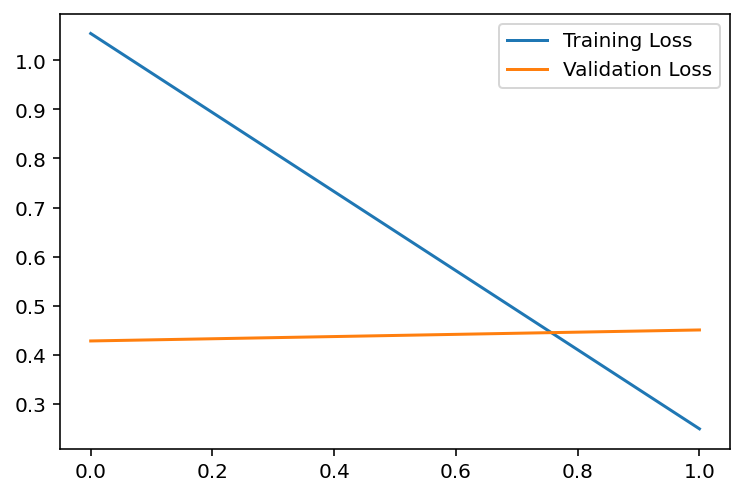

In [ ]:
plt.plot(my_MLP.loss_during_training,label='Training Loss')
plt.plot(my_MLP.valid_loss_during_training,label='Validation Loss')
plt.legend()

On the previous graph we can see that with only 2 epoch the MLP is almost memorizing so by early stopping at 2 we are avoiding the full memorization of the hole trainset

In [ ]:
my_MLP.eval()
print(my_MLP.eval_performance(trainloader))
print(my_MLP.eval_performance(validloader))
print(my_MLP.eval_performance(testloader))

fit_time = time.time() 
results_TFIDF["MLP"]=float(my_MLP.eval_performance(testloader).detach().numpy())
fit_time = time.time() - fit_time

fit_time_TFIDF["MLP"] = fit_time

tensor(0.9884)
tensor(0.8909)
tensor(0.8801)


In [ ]:
subreddit2label[my_MLP.classify(trainloader,300)]

'truegaming'

### 2.4 Plotting Results

In [ ]:
#Load saved results in order to plot without doing the crossvalidation
"""
results_TFIDF = pd.read_pickle(r"https://storage.googleapis.com/enver-bucket/data/crossval_dictio/TFIDF_results.pickle")
TFIDF_crossval = pd.read_pickle(r"https://storage.googleapis.com/enver-bucket/data/crossval_dictio/TFIDF_crossval.pickle")
fit_time_TFIDF = pd.read_pickle(r"https://storage.googleapis.com/enver-bucket/data/crossval_dictio/TFIDF_fit_time.pickle")

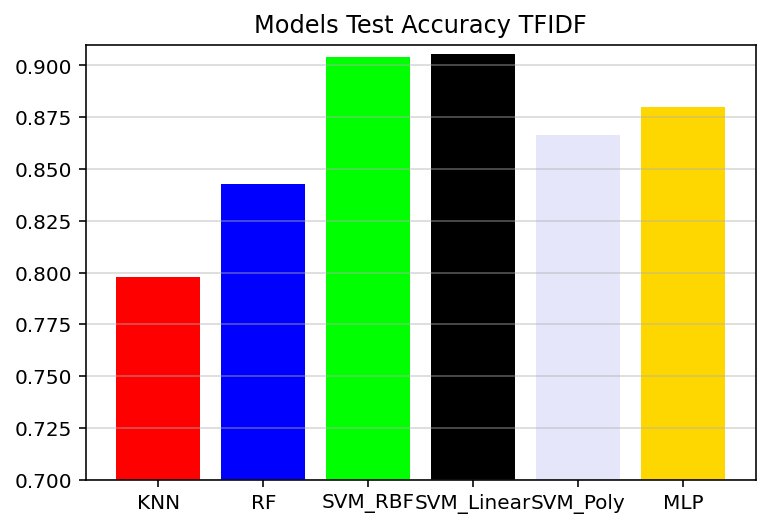

In [ ]:
plt.bar(range(len(results_TFIDF)), list(results_TFIDF.values()), align='center',color=['red', 'blue', 'lime', 'black', 'lavender','gold'])
plt.xticks(range(len(results_TFIDF)), list(results_TFIDF.keys()))
plt.ylim((0.7,0.91))
plt.grid(alpha=0.5,axis="y")
plt.title("Models Test Accuracy TFIDF")

plt.show()

We can see that the TFIDF as expected has in general better results than the LDA representation. The linear SVM seems to be the model wich gets the best accuracy but the SVM_RBF and the MLP are pretty close too. KNN as is performing not too well and we suspect that is because the initial PCA projection. Also say that the MLP is the only model that can hanndle the +9000 variables in a reasonable time, this is due too that Neural Networks are highly GPU parallelizable.


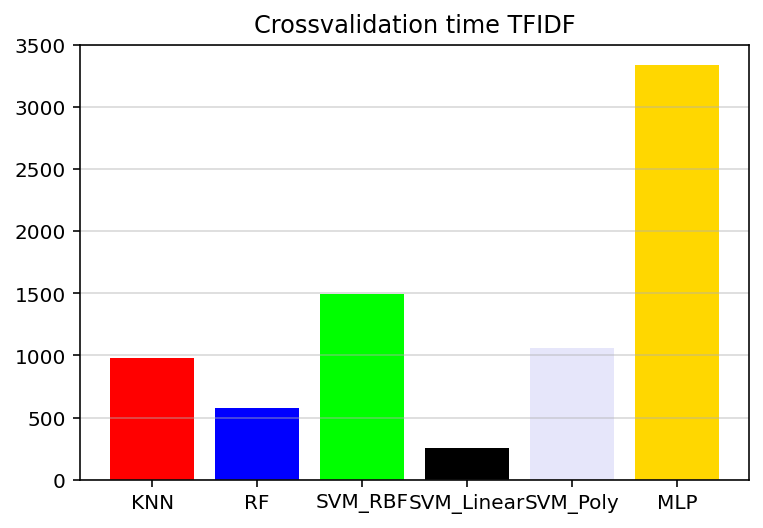

In [ ]:
plt.bar(range(len(crossval_time_TFIDF)), list(crossval_time_TFIDF.values()), align='center',color=['red', 'blue', 'lime', 'black', 'lavender','gold'])
plt.xticks(range(len(crossval_time_TFIDF)), list(crossval_time_TFIDF.keys()))
plt.grid(alpha=0.5,axis="y")
plt.title("Crossvalidation time TFIDF")

plt.show()

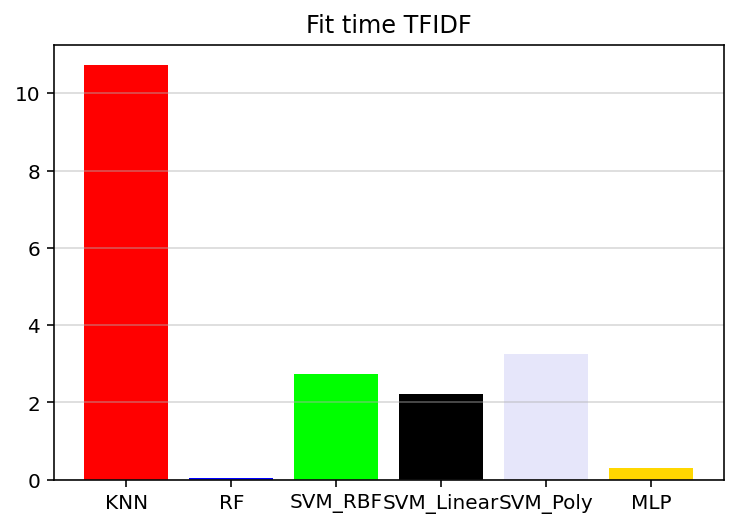

In [ ]:
plt.bar(range(len(fit_time_TFIDF)), list(fit_time_TFIDF.values()), align='center',color=['red', 'blue', 'lime', 'black', 'lavender','gold'])
plt.xticks(range(len(fit_time_TFIDF)), list(fit_time_TFIDF.keys()))
plt.grid(alpha=0.5,axis="y")
plt.title("Fit time TFIDF")

plt.show()

If we take into account the fitting time along with the accuracy, we can see that the MLP would be the better time to performance candidate.

## 3. Final model and Conclusions

For this last part, we are going to compare all the LDA and TFIDF graphs and also try the best model with a better PCA projection of the data.

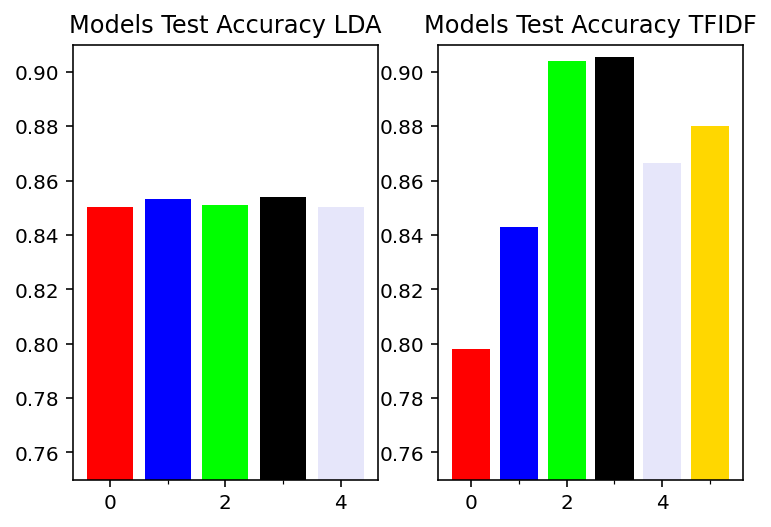

In [ ]:
fig,ax=plt.subplots(1,2)
warnings.filterwarnings("ignore")

ax[0].bar(range(len(results_LDA)), list(results_LDA.values()), align='center',color=['red', 'blue', 'lime', 'black', 'lavender'])
ax[0].set_xticks(range(len(results_LDA)), list(results_LDA.keys()))
ax[0].set_ylim((0.75,0.91))
ax[0].set_title("Models Test Accuracy LDA")


ax[1].bar(range(len(results_TFIDF)), list(results_TFIDF.values()), align='center',color=['red', 'blue', 'lime', 'black', 'lavender','gold'])
ax[1].set_xticks(range(len(results_TFIDF)), list(results_TFIDF.keys()))
ax[1].set_ylim((0.75,0.91))
ax[1].set_title("Models Test Accuracy TFIDF")

plt.show()


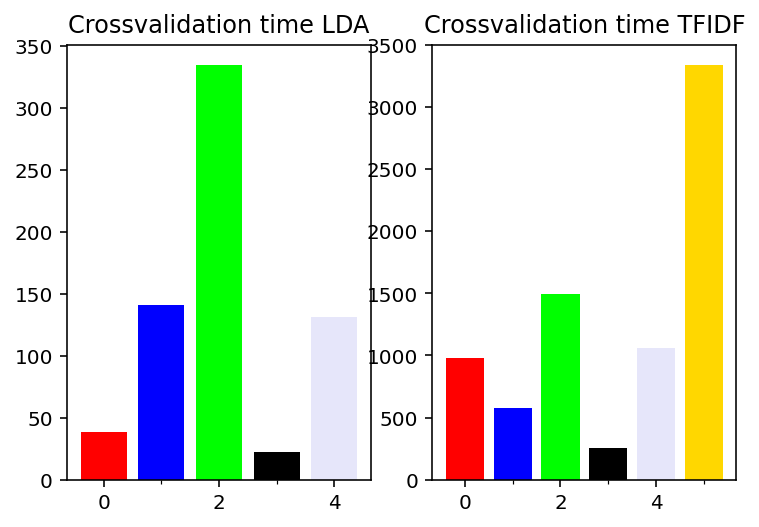

In [ ]:
fig,ax=plt.subplots(1,2)

ax[0].bar(range(len(crossval_time_LDA)), list(crossval_time_LDA.values()), align='center',color=['red', 'blue', 'lime', 'black', 'lavender'])
ax[0].set_xticks(range(len(crossval_time_LDA)), list(crossval_time_LDA.keys()))
ax[0].set_title("Crossvalidation time LDA")


ax[1].bar(range(len(crossval_time_TFIDF)), list(crossval_time_TFIDF.values()), align='center',color=['red', 'blue', 'lime', 'black', 'lavender','gold'])
ax[1].set_xticks(range(len(crossval_time_TFIDF)), list(crossval_time_TFIDF.keys()))
ax[1].set_title("Crossvalidation time TFIDF")

plt.show()

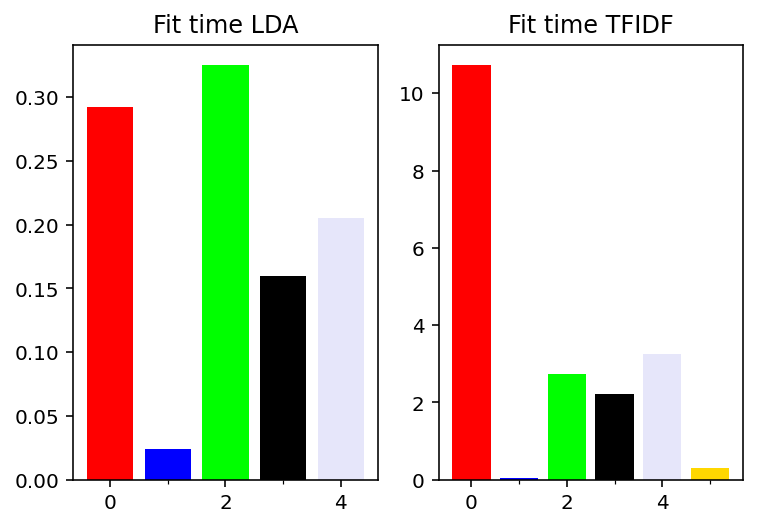

In [ ]:
fig,ax=plt.subplots(1,2)

ax[0].bar(range(len(fit_time_LDA)), list(fit_time_LDA.values()), align='center',color=['red', 'blue', 'lime', 'black', 'lavender'])
ax[0].set_xticks(range(len(fit_time_LDA)), list(fit_time_LDA.keys()))
ax[0].set_title("Fit time LDA")


ax[1].bar(range(len(fit_time_TFIDF)), list(fit_time_TFIDF.values()), align='center',color=['red', 'blue', 'lime', 'black', 'lavender','gold'])
ax[1].set_xticks(range(len(fit_time_TFIDF)), list(fit_time_TFIDF.keys()))
ax[1].set_title("Fit time TFIDF")

plt.show()

In [ ]:
#Saving the results of the crossvalidations

"""pickle.dump(results_LDA,open("/content/drive/My Drive/Machine Learning Applications/LDA_results.pickle",'wb'))
pickle.dump(results_TFIDF,open("/content/drive/My Drive/Machine Learning Applications/TFIDF_results.pickle",'wb'))

pickle.dump(fit_time_LDA,open("/content/drive/My Drive/Machine Learning Applications/LDA_fit_time.pickle",'wb'))
pickle.dump(fit_time_TFIDF,open("/content/drive/My Drive/Machine Learning Applications/TFIDF_fit_time.pickle",'wb'))

pickle.dump(crossval_time_LDA,open("/content/drive/My Drive/Machine Learning Applications/LDA_crossval.pickle",'wb'))
pickle.dump(crossval_time_TFIDF,open("/content/drive/My Drive/Machine Learning Applications/TFIDF_crossval.pickle",'wb'))"""

In [ ]:
#We use the best model with its best parameters but with a better projection of the data
#TFIDF is give us a better accuracy than LDA but with a higher computational cost

best_model = SVC(kernel = "linear",C=10)
X = TFIDF_df.drop("labels",axis=1)
y = TFIDF_df["labels"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

PCA_time = time.time() 
my_pca = PCA(n_components=3000).fit(X_train) #With this number of components we can generalize more as we are getting above 85% of the variance explain
X_train = my_pca.transform(X_train)
X_test = my_pca.transform(X_test)
PCA_time =  time.time() - PCA_time

eigenvalues = my_pca.explained_variance_

print("Total time for PCA: " + str(PCA_time))
print("Total variance explain: " + str(sum(eigenvalues)))
best_model.fit(X_train,y_train)
#Best Model Predictions
best_model_predict = best_model.predict(X_test)

fit_time = time.time() 
best_model_score = best_model.score(X_test, y_test)
fit_time =  time.time() - fit_time

print("Total time for fitting the model: " + str(fit_time))
print("Total time for projction and fit: " + str(fit_time + PCA_time))


Total time for PCA: 194.53274941444397
Total variance explain: 0.8788732106850734
Total time for fitting the model: 65.92494988441467
Total time for projction and fit: 260.45769929885864


In [ ]:
print(subreddit2label)
print("\n=== Confusion Matrix ===")
print(confusion_matrix(y_test, best_model_predict))
print("\n=== Classification Report ===")
print(classification_report(y_test, best_model_predict))
print("Final model accuracy: "+str(best_model_score))

{0: 'medicine', 1: 'books', 2: 'datascience', 3: 'truegaming', 4: 'PoliticalDiscussion', 5: 'DebateReligion', 6: 'investing', 7: 'relationships', 8: 'CasualConversation', 9: 'legaladvice'}

=== Confusion Matrix ===
[[200   1   0   1   5   1   3   1   7  10]
 [  0 230   0   4   2   3   0   2  13   2]
 [  3   0 206   2   0   0   0   0   5   2]
 [  2   4   1 417   1   1   1   2   5   0]
 [  3   2   0   0 299   2   6   0   3   2]
 [  2   2   1   1   3 396   0   0   0   0]
 [  6   2   3   2  12   1 252   0   3   0]
 [  1   0   1   0   0   1   0 453  28  19]
 [  6   3   2   8   2   3   1  49 202  21]
 [ 12   0   1   1   2   0   2  39   9 411]]

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       229
           1       0.94      0.90      0.92       256
           2       0.96      0.94      0.95       218
           3       0.96      0.96      0.96       434
           4       0.92      0.94      0.93       31

We can see that although we are using a better projection the results are not improving a lot (indeed they are worse), the fit time is increasing.

As a conclusion, we can see that bouth LDA and TFIDF can give a decent classification accuracy. If we want an instataneous system with not a bad accuracy, the better model would be to use a Random Forest with the LDA representation. On the other hand if you want the maximum accuracy possible you would prefer to use Linear SVM with TFIDF, but, if you want a balance between time and accuracy, the MLP with TFIDF would be the best option.